In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import cm

In [2]:
import matplotlib.animation as anim
import mycolormaps as mycmap
import mapstyle as ms
import open_experiment as of
import cartopy.crs as ccrs
import numpy as np

In [3]:
import tobac
import iris
from IPython.display import HTML, Image, display

In [4]:
import time

In [5]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [6]:
def update_lon(ds,longitude='lon'):
    ds.coords[longitude] = (ds.coords[longitude] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    return ds

In [7]:
path='/scratch/wcq7pz/exp_levante_post/'

In [8]:
import detect_objects as obj
grid_area = xr.open_dataset('gridarea_dom3p5.nc')
grid_area.coords['lon'] = (grid_area.coords['lon'] + 180) % 360 - 180
grid_area = grid_area.sortby(grid_area.lon)

In [9]:
sum_control_land = xr.open_dataset('sum_control_land.nc')
sum_fixedSM_land = xr.open_dataset('sum_fixedSM_land.nc')

In [10]:
topo5km = xr.open_dataset('../exp_levante_post/topography_dom03_5km.nc')
topo5km.coords['lon'] = (topo5km.coords['lon'] + 180) % 360 - 180
topo5km  = topo5km.sortby(topo5km.lon)


In [11]:
# Repeat the variable along the time dimension of ds2
ds_topo = topo5km['topography_c'].broadcast_like(sum_control_land['time'])

In [12]:
AB_SM_control = sum_control_land.sel(lat=slice(-7,3),lon=slice(-73,-58)).copy()
AB_SM_fixedSM = sum_fixedSM_land.sel(lat=slice(-7,3),lon=slice(-73,-58)).copy()

In [13]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [14]:
# Create a function to calculate spatial standard deviations for a given box size
def calculate_std_dev(size,ds,topo):

    # Create an empty array to store standard deviations
    std_devs = np.zeros(num_samples)
    box_centers = []  # List to store center points
    # Start measuring the execution time
    start_time = time.time()
    
    for i in range(num_samples):
        # Select a random time index
        time_index = np.random.randint(0, len(ds.time))
        #print(ds.isel(time=time_index).time)
        # Select a random coordinate for the lower-left corner of the box within the domain
        lon_random = np.random.uniform(lon_min, lon_max - size * grid_size)
        lat_random = np.random.uniform(lat_min, lat_max - size * grid_size)
        #print(lon_random,lat_random)
        # Calculate the box coordinates
        box_lon_min = lon_random
        box_lon_max = lon_random + size * grid_size
        box_lat_min = lat_random
        box_lat_max = lat_random + size * grid_size


        # Create a mask for the current random box
        box_mask = (
            (ds['lon'] >= box_lon_min) &
            (ds['lon'] <= box_lon_max) &
            (ds['lat'] >= box_lat_min) &
            (ds['lat'] <= box_lat_max)
        )
        if (topo.isel(time=time_index).where(box_mask).median()<500)&(topo.isel(time=time_index).where(box_mask).std()<150):
            
            # Calculate the spatial standard deviation within the box
            std_devs[i] = ds['w_so'].isel(time=time_index).where(box_mask).std()
        else:
            std_devs[i] = np.nan
        # Calculate the center points of the box
        center_lon = (box_lon_min + box_lon_max) / 2
        center_lat = (box_lat_min + box_lat_max) / 2
        box_centers.append((center_lat, center_lon))
    

    # Stop measuring the execution time
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time

    print(f"Elapsed time: {elapsed_time} seconds")

    return std_devs, box_centers



In [15]:
# Define the desired box sizes in square kilometers
box_sizes_km2 = [2500,3500,5000, 6000,7000,8000,9000,10000,12500,15000, 17500,20000]; 
grid_size_deg = 0.045

# Calculate the number of grid points for each box size
num_grid_points = []

for size_km2 in box_sizes_km2:
    # Calculate the number of grid points along one dimension (e.g., latitude or longitude)
    num_points = int(np.sqrt(size_km2 ) / (grid_size_deg*110))

    num_grid_points.append((num_points, num_points))  # Assuming square boxes

# Print the results
for size_km2, num_points in zip(box_sizes_km2, num_grid_points):
    print(f"Box Size: {size_km2} km^2, Number of Grid Points (lat x lon): {num_points[0]} x {num_points[1]}")

Box Size: 2500 km^2, Number of Grid Points (lat x lon): 10 x 10
Box Size: 3500 km^2, Number of Grid Points (lat x lon): 11 x 11
Box Size: 5000 km^2, Number of Grid Points (lat x lon): 14 x 14
Box Size: 6000 km^2, Number of Grid Points (lat x lon): 15 x 15
Box Size: 7000 km^2, Number of Grid Points (lat x lon): 16 x 16
Box Size: 8000 km^2, Number of Grid Points (lat x lon): 18 x 18
Box Size: 9000 km^2, Number of Grid Points (lat x lon): 19 x 19
Box Size: 10000 km^2, Number of Grid Points (lat x lon): 20 x 20
Box Size: 12500 km^2, Number of Grid Points (lat x lon): 22 x 22
Box Size: 15000 km^2, Number of Grid Points (lat x lon): 24 x 24
Box Size: 17500 km^2, Number of Grid Points (lat x lon): 26 x 26
Box Size: 20000 km^2, Number of Grid Points (lat x lon): 28 x 28


In [16]:
#Bounds
lon_min, lon_max = -73, -58 
lat_min, lat_max = -7, 3 

# Define fixed box sizes in grid points
grid_size = 0.045  # Grid size in degrees
box_sizes = [15,16,18,19,20,22,24,26,28,31,34,37,40]  # Number of grids in each dimension

# Convert box sizes to degrees
box_sizes_deg = [size * grid_size for size in box_sizes]

# Number of random samples
num_samples = 1000

In [17]:
# del(results_control,SMstd_control,centers_control)
# Calculate standard deviations for each box size
results_control = {size: calculate_std_dev(size,AB_SM_control,ds_topo) for size in box_sizes}
SMstd_control = {size: result[0] for size, result in results_control.items()}
centers_control = {size: result[1] for size, result in results_control.items()}

Elapsed time: 9.587080955505371 seconds
Elapsed time: 8.354809522628784 seconds
Elapsed time: 7.868926048278809 seconds
Elapsed time: 7.764848947525024 seconds
Elapsed time: 7.713278532028198 seconds
Elapsed time: 7.649331331253052 seconds
Elapsed time: 7.643383502960205 seconds
Elapsed time: 7.661965847015381 seconds
Elapsed time: 7.664596796035767 seconds
Elapsed time: 7.5708513259887695 seconds
Elapsed time: 7.579064846038818 seconds
Elapsed time: 7.575360059738159 seconds
Elapsed time: 7.858503103256226 seconds


In [18]:
# del(results_fixedSM,SMstd_fixedSM,centers_fixedSM)
# Calculate standard deviations for each box size
results_fixedSM = {size: calculate_std_dev(size,AB_SM_fixedSM,ds_topo) for size in box_sizes}
SMstd_fixedSM = {size: result[0] for size, result in results_fixedSM.items()}
centers_fixedSM = {size: result[1] for size, result in results_fixedSM.items()}

Elapsed time: 9.399820327758789 seconds
Elapsed time: 8.366615295410156 seconds
Elapsed time: 7.90228796005249 seconds
Elapsed time: 7.759553909301758 seconds
Elapsed time: 7.703046798706055 seconds
Elapsed time: 7.625471353530884 seconds
Elapsed time: 7.597307443618774 seconds
Elapsed time: 7.561395883560181 seconds
Elapsed time: 7.582640886306763 seconds
Elapsed time: 7.565683841705322 seconds
Elapsed time: 7.552078008651733 seconds
Elapsed time: 7.544987440109253 seconds
Elapsed time: 7.556408405303955 seconds


In [19]:
colors_exp = {'control': 'darkcyan', 'fixedSM': 'dimgrey'}
lw = 1.5

In [20]:
outplot = '/scratch/wcq7pz/output_plots/'

In [21]:
# Calculate the mean and standard error for each box size
mean_std_devs_f = {size: np.nanmean(result) for size, result in SMstd_fixedSM.items()}
std_errors_f = {size: np.nanstd(result)  for size, result in SMstd_fixedSM.items()}

mean_std_devs_c = {size: np.nanmean(result) for size, result in SMstd_control.items()}
std_errors_c = {size: np.nanstd(result)  for size, result in SMstd_control.items()}

# Create lists of box sizes, means, and standard errors for plotting
box_sizes_list_f = list(mean_std_devs_f.keys()); mean_std_devs_list_f = list(mean_std_devs_f.values()); std_errors_list_f = list(std_errors_f.values())
box_sizes_list_c = list(mean_std_devs_c.keys()); mean_std_devs_list_c = list(mean_std_devs_c.values()); std_errors_list_c = list(std_errors_c.values())



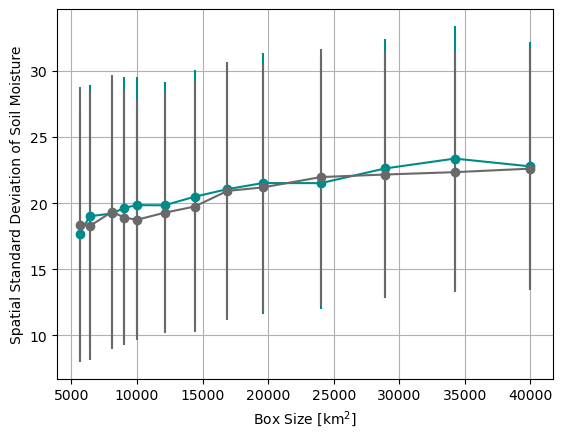

In [22]:
# Create the plot
plt.errorbar( [(el * 5)**2 for el in box_sizes_list_c], mean_std_devs_list_c, yerr=std_errors_list_c, color=colors_exp['control'],marker='o', linestyle='-')
plt.errorbar( [(el * 5)**2 for el in box_sizes_list_f], mean_std_devs_list_f, yerr=std_errors_list_f, color=colors_exp['fixedSM'],marker='o', linestyle='-')

plt.xlabel('Box Size [km$^2$]'); plt.ylabel('Spatial Standard Deviation of Soil Moisture');  plt.grid(True);

plt.savefig(outplot+"figure_S2.pdf", format="pdf",dpi=300,  bbox_inches="tight", transparent=True)